In [1]:
from more_itertools import pairwise
import itertools
import igraph as ig
import random
import colorsys


In [2]:
period = 'april2022'
path = '../data/' + period + '/'

In [3]:
def to_stop_tuples(data_path):
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        # Skip first item, than pairwise
        for line1, line2 in pairwise(itertools.islice(lines, 1, None)):
            route_id1, _, stop_seq1, stop_id1, _ = line1.split(';')
            route_id2, _, stop_seq2, stop_id2, _ = line2.split(';')
            if route_id1 == route_id2 and int(stop_seq2) > int(stop_seq1):               
                yield (route_id1, stop_id1, stop_id2)


In [4]:
def get_stops(data_path):
    stops = dict()
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        for l in itertools.islice(lines, 1, None):  # Skip first item
            stop_id, _, stop_name, _, stop_lat, stop_lon, _, _, _ = l.split(',')
            stops[stop_id] = (stop_name, float(stop_lat), float(stop_lon))
    return stops

In [5]:
def rand_color():
    h, s, l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r, g, b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return (r / 255, g / 255, b / 255) 

In [6]:
tratte_data = path + 'processed/tratte.csv'
stops_data = path + 'original/stops.txt'

In [7]:
from collections import Counter
# Tratte data
tratte_tuple = set(to_stop_tuples(tratte_data))
n_train = dict (Counter (to_stop_tuples(tratte_data)))

# Stops data
stops = get_stops(stops_data)

# Routes data
routes = { route_id for route_id, _, _ in tratte_tuple }
# Routes color
routes_color = { route_id : rand_color() for route_id in routes }

In [8]:
g = ig.Graph(directed=True)

g.add_vertices(
    n = list(stops.keys()), 
    attributes = {
        'label': [label for label, _, _ in stops.values()],
        'lat': [lat for _, lat, _ in stops.values()],
        'lon': [lon for _, _, lon in stops.values()]
    }
)

g.add_edges(
    es = [(stop_id1, stop_id2) for _, stop_id1, stop_id2 in tratte_tuple],
    attributes = {
        'label': [route_id for route_id, _, _ in tratte_tuple],
        'color': [routes_color[route_id] for route_id, _, _ in tratte_tuple],
        'num_train': [n_train[route_id, stop_id1, stop_id2]  for route_id, stop_id1, stop_id2 in tratte_tuple]
    }
)

In [9]:
g.summary()


'IGRAPH DN-- 428 1706 -- \n+ attr: label (v), lat (v), lon (v), name (v), color (e), label (e), num_train (e)'

In [10]:
# Save the graph
save_path = '../data/graphs/' + period + '.graphml' 
g.write_graphml(save_path)

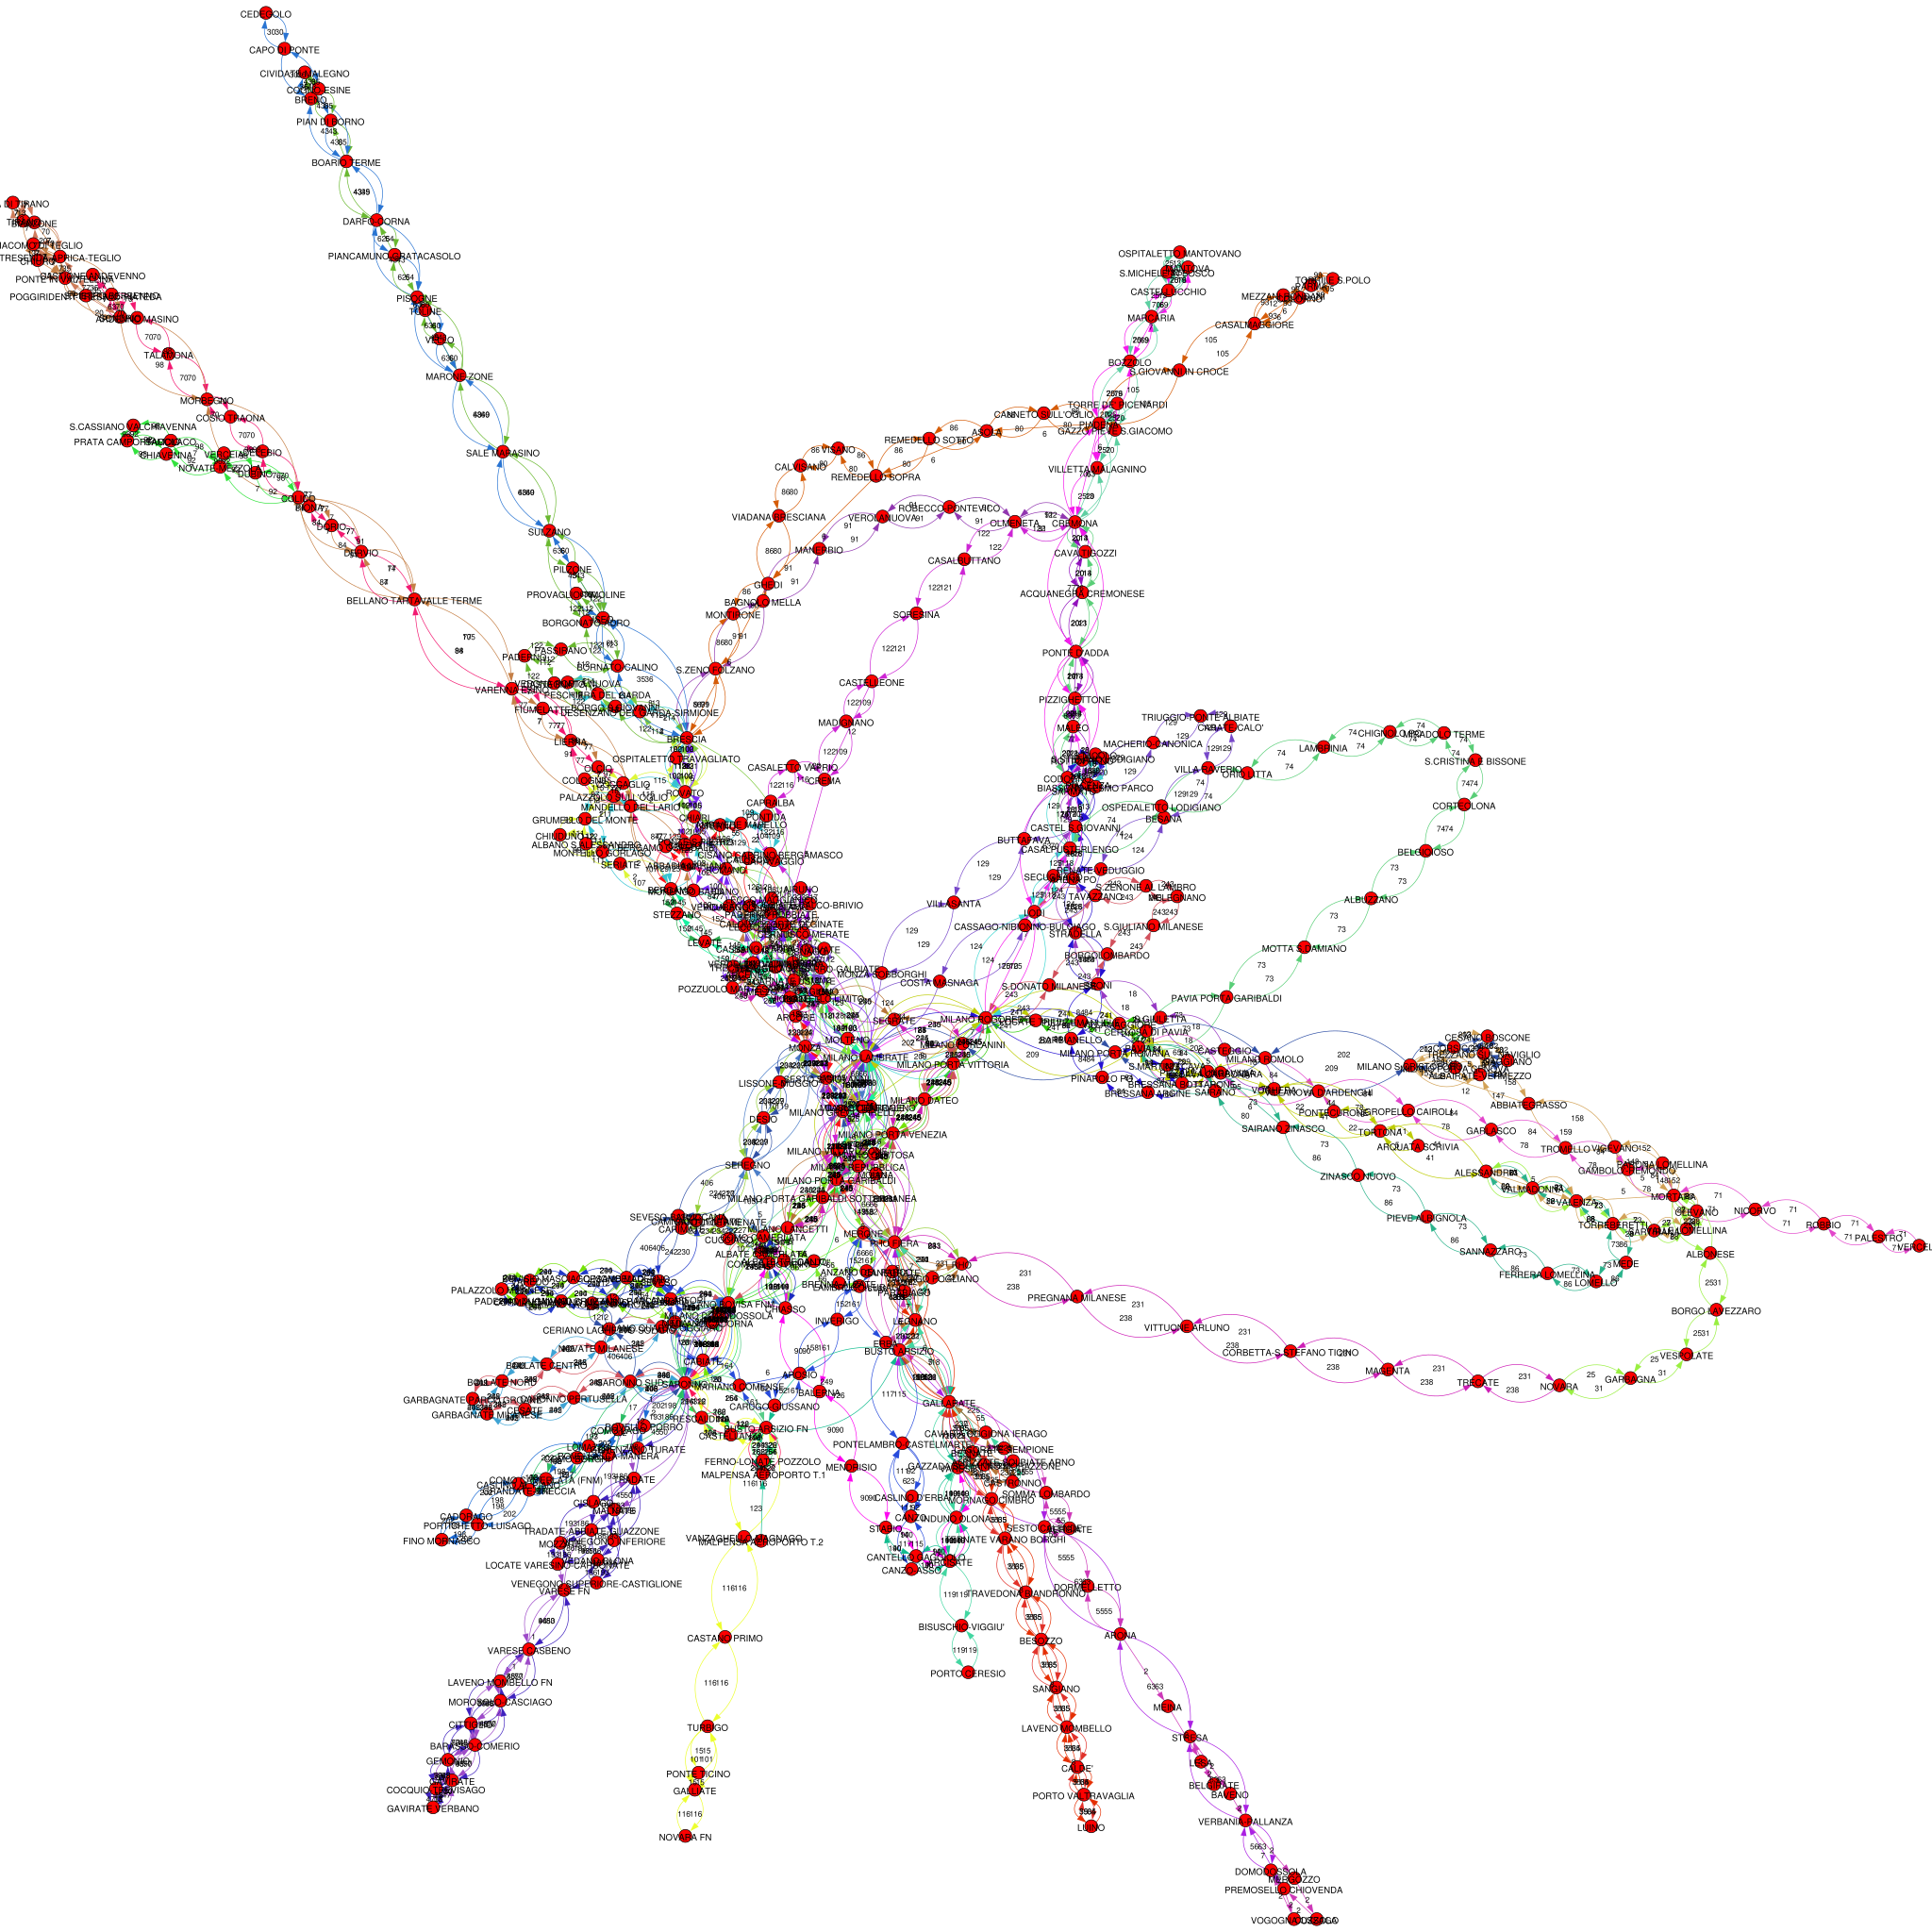

In [11]:
visual_style = {} #Python dictionary
visual_style["edge_label"] = g.es["num_train"]
visual_style["layout"] = g.layout_auto()

ig.plot(g, bbox=(0, 0, 3000, 3000), **visual_style)